# ***화승***

## ***IMPORT LIBRARY***
---

In [85]:
### Library Import 
import os
import re
import sys
import glob
import shap
import optuna
import pickle
import warnings
import numpy as np 
import pandas as pd 
import seaborn as sns
import xgboost as xgb
from tqdm import tqdm
from scipy import stats
import statsmodels.api as sm
from functools import partial
from pandarallel import pandarallel
from xgboost import XGBRegressor, callback as xgb_callback
from datetime import timedelta, time, datetime
from scipy.stats import truncnorm
from IPython.display import Image
from optbinning import OptimalBinning
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.font_manager as fm
import matplotlib.patches as patches
from matplotlib.dates import AutoDateLocator, AutoDateFormatter
warnings.filterwarnings('ignore')
plt.rc('font', family='Apple SD Gothic Neo')

# Pandas 옵션 설정 
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', None)

# Scikit-Learn 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import KFold
from skopt import gp_minimize
from skopt.space import Integer, Real, Categorical
from skopt.utils import use_named_args
from skopt.plots import plot_convergence 

# Import fns 
from utils import * 
from hwaseung_fn import * 

## ***Load Dataset***
---

In [86]:
### Cluster Dict 
cluster_dict = {
        'cluster1': {'products': ["FFWED70284","FFWED70007","FFWED70267","FFWED70103","FFWED70199","FFSED70438","FFWED70033",
                                "FFWES60194","FFSED70498","FFSED70533","FFWED70321"],
                    'var': 'T5'},
        'cluster2': {'products': ["FFWED70019","FFWED70102","FFWED70283","FFHED70076","FFWED70338",
                                "FFHED70014","FFSED70032","FFHED70147",
                                "FFHED60009","FFHED60006"],
                    'var': 'T3'},
        'cluster3': {'products': ["HCSED50105", "HCSED60072",
                                "HCWED60031", "HCSED50391", "HCSED70092", "HCSED60024",],
                    'var': 'M/B 점도 (ML)'},
        'cluster4': {'products': ["HCSED60010", "HCSES60015", "HCWES60017",
                                "HCSED70584", "HCSED60530", "HCSED50047",
                                "HCSED40011", "HCSED20006",
                                "HCWED70019", "FCHED60002", "FCWED70009",
                                "HCSED60017", "HCSED70143"],
                    'var': 'M/B 점도 (MS)'}
        }

# Random Seed & Path 
random_seed = 22
path = '/Users/hwijongim/Library/CloudStorage/OneDrive-앰버로드/문서 - Solution/2502_화승/20.수행/22.분석과제/250408_분석_sm'

# Product 정의 
train_cluster = "cluster1"
p_codes = cluster_dict['cluster1']['products']  

# Target 
target_list = ["Ct 90"] + ["Scorch (T5)", "Scorch (T3)"] + ['Vm (T5)', "Vm (T3)", "M/B 점도 (ML)", "M/B 점도 (MS)"] + ["경도"]

# Data Import 
        # Log 
log_df = pd.read_csv(f"{path}/log_df_10s.csv")
log_df = log_df[log_df["제품코드"].isin(cluster_dict[train_cluster]["products"])] 
        # QA 
qa_df = pd.read_csv(f"{path}/qa_df.csv") 
        # Recipe
recipe_df = pd.read_csv(f"{path}/recipe_df.csv") 
        # INFO 
info = pd.read_excel(f"{path}/투입자재 CODE별 비중 정보.xlsx", header=1, index_col=0).reset_index(drop=True)
        # Weather 
weather_df = pd.read_csv(f"{path}/weather_dg.csv")
weather_df["연월일"] = weather_df["연월일"].astype(str)

# Print 
print('='*100)
print(f'Log Dataset: {log_df.shape}')
print(f'QA Dataset: {qa_df.shape}')
print(f'Recipe Dataset: {recipe_df.shape}')
print(f'INFO Dataset: {info.shape}')
print(f'Weather Dataset: {weather_df.shape}')
print('='*100)

Log Dataset: (2389691, 37)
QA Dataset: (334291, 16)
Recipe Dataset: (1813072, 13)
INFO Dataset: (80, 2)
Weather Dataset: (1268, 5)


## ***Data Preprocessing***
---

In [87]:
### Log Dataset 정제 
log_df4, log_df5 = prep_log(log_df)

# Print 
print('='*100)
print(f'Log Dataset: {log_df4.shape}')
print(f'Log Train Dataset: {log_df5.shape}')
print('='*100)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
Log Dataset: (2176948, 39)
Log Train Dataset: (33311, 15)


In [88]:
### QA Dataset 정제 
qa_df4, qa_df5 = prep_qa(qa_df, p_codes, target_list)

# Print 
print('='*100)
print(f'Qa Dataset: {qa_df4.shape}')
print(f'Qa Train Dataset: {qa_df5.shape}')
print('='*100)

Qa Dataset: (95239, 4)
Qa Train Dataset: (44297, 9)


In [89]:
### Recipe Dataset 정제 
recipe_df = prep_recipe(recipe_df, info) 

# Print 
print('='*100)
print(f'Recipe Dataset: {recipe_df.shape}')
print('='*100)

Recipe Dataset: (123200, 2)


In [90]:
### Concat Dataset 
df1 = pd.merge(left=log_df5, right=qa_df5, on="작업지시번호-배치", how="left")
df2 = pd.merge(left=df1, right=recipe_df, on="작업지시번호-배치", how="left")
df3 = pd.merge(left=df2, right=weather_df, on="연월일", how="left").drop(["연월일"], axis=1)    

# Print 
print('='*100)
print(f'Daset Shape: {df3.shape}')
print('='*100)


Daset Shape: (33311, 27)


In [91]:
### Cluster label 생성 
clst = {1: ['FFWED70267', 'FFWED70033'],
        2: ['FFWED70007', 'FFWED70103'],
        3: ['FFSED70498', 'FFWED70321'],
        4: ['FFSED70438', 'FFSED70533'],
        5: ['FFWES60194'],
        6: ['FFWED70284', 'FFWED70199']}

# 1) 제품코드 추출
df3["제품코드_extracted"] = df3["작업지시번호-배치"].str[6:16]

# 2) 매핑 dict 생성
code_to_cluster = {c: k for k, codes in clst.items() for c in codes}

# 3) 매핑 적용 
df3["cluster"] = df3.get("cluster", pd.Series(index=df3.index))
df3["cluster"] = df3["cluster"].fillna(df3["제품코드_extracted"].map(code_to_cluster))
df3["cluster"] = df3["cluster"].astype("Int64")

df3 = df3.drop(columns=["제품코드_extracted"])
dataset = df3.drop(columns=['cluster']).reset_index(drop=True).copy()  

# Print 
print('='*100)
print(f'Train Dataset Shape: {dataset.shape}')
print('='*100)

Train Dataset Shape: (33311, 27)


## ***MODELLING***
---

In [92]:
### Train Test Split 
# Targets 
targets = ['cycle time','Ct 90_결과','Scorch (T5)_결과','Vm (T5)_결과','경도_결과']

# Cycle Time 
cycle_train_dataset, cycle_test_dataset = create_train_test_dataset(dataset, targets[0])

# CT90 
ct_train_dataset, ct_test_dataset = create_train_test_dataset(dataset, targets[1])

# Scorch 
sc_train_dataset, sc_test_dataset = create_train_test_dataset(dataset, targets[2])

# Vm 
vm_train_dataset, vm_test_dataset = create_train_test_dataset(dataset, targets[3])

# Hard 
hard_train_dataset, hard_test_dataset = create_train_test_dataset(dataset, targets[4])

# Print 
print('='*100)
print(f"{'cycle time':<21} | {len(cycle_train_dataset):>14,} | {len(cycle_test_dataset):>13,}")
print(f"{'Ct 90_결과':<20} | {len(ct_train_dataset):>14,} | {len(ct_test_dataset):>13,}")
print(f"{'Scorch (T5)_결과':<20} | {len(sc_train_dataset):>14,} | {len(sc_test_dataset):>13,}")
print(f"{'Vm (T5)_결과':<20} | {len(vm_train_dataset):>14,} | {len(vm_test_dataset):>13,}")
print(f"{'경도_결과':<19} | {len(hard_train_dataset):>14,} | {len(hard_test_dataset):>13,}") 
print("="*100)

cycle time            |         21,588 |         5,064
Ct 90_결과             |         13,541 |         3,177
Scorch (T5)_결과       |          9,329 |         2,189
Vm (T5)_결과           |          9,329 |         2,189
경도_결과               |         12,888 |         3,024


[I 2025-10-16 15:49:28,464] A new study created in memory with name: no-name-78363bc4-5370-4e0b-9419-7836fe741ffb


학습할 Tree Features: 16 | ['step1_Ram 압력', 'step2_Ram 압력', 'step3_Ram 압력', 'step1_Rotor speed', 'step2_Rotor speed', 'step3_Rotor speed', 'step1_mix온도', 'step2_mix온도', 'step3_mix온도', 'step1_time', 'step2_time', 'step3_time', '필팩터', 'TA_AVG', 'TA_MAX', 'TA_MIN']
학습 Tree 데이터 수: 21588


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-10-16 15:49:41,399] Trial 0 finished with value: 4.3781940134701935 and parameters: {'n_estimators': 2877, 'max_depth': 10, 'learning_rate': 0.008820236181414396, 'subsample': 0.8970507063255918, 'gamma': 0.01057839494244206, 'reg_lambda': 0.19498296116862474}. Best is trial 0 with value: 4.3781940134701935.
[I 2025-10-16 15:49:43,716] Trial 1 finished with value: 4.493865590045079 and parameters: {'n_estimators': 1235, 'max_depth': 12, 'learning_rate': 0.19816182251942951, 'subsample': 0.7862941787733025, 'gamma': 0.3826474958054999, 'reg_lambda': 0.010744599511080314}. Best is trial 0 with value: 4.3781940134701935.
[I 2025-10-16 15:49:47,844] Trial 2 finished with value: 5.371924609481328 and parameters: {'n_estimators': 506, 'max_depth': 10, 'learning_rate': 0.004827637194813487, 'subsample': 0.8435308945293899, 'gamma': 0.12773453563820858, 'reg_lambda': 1.3603052941991567}. Best is trial 0 with value: 4.3781940134701935.
[I 2025-10-16 15:49:55,113] Trial 3 finished with v

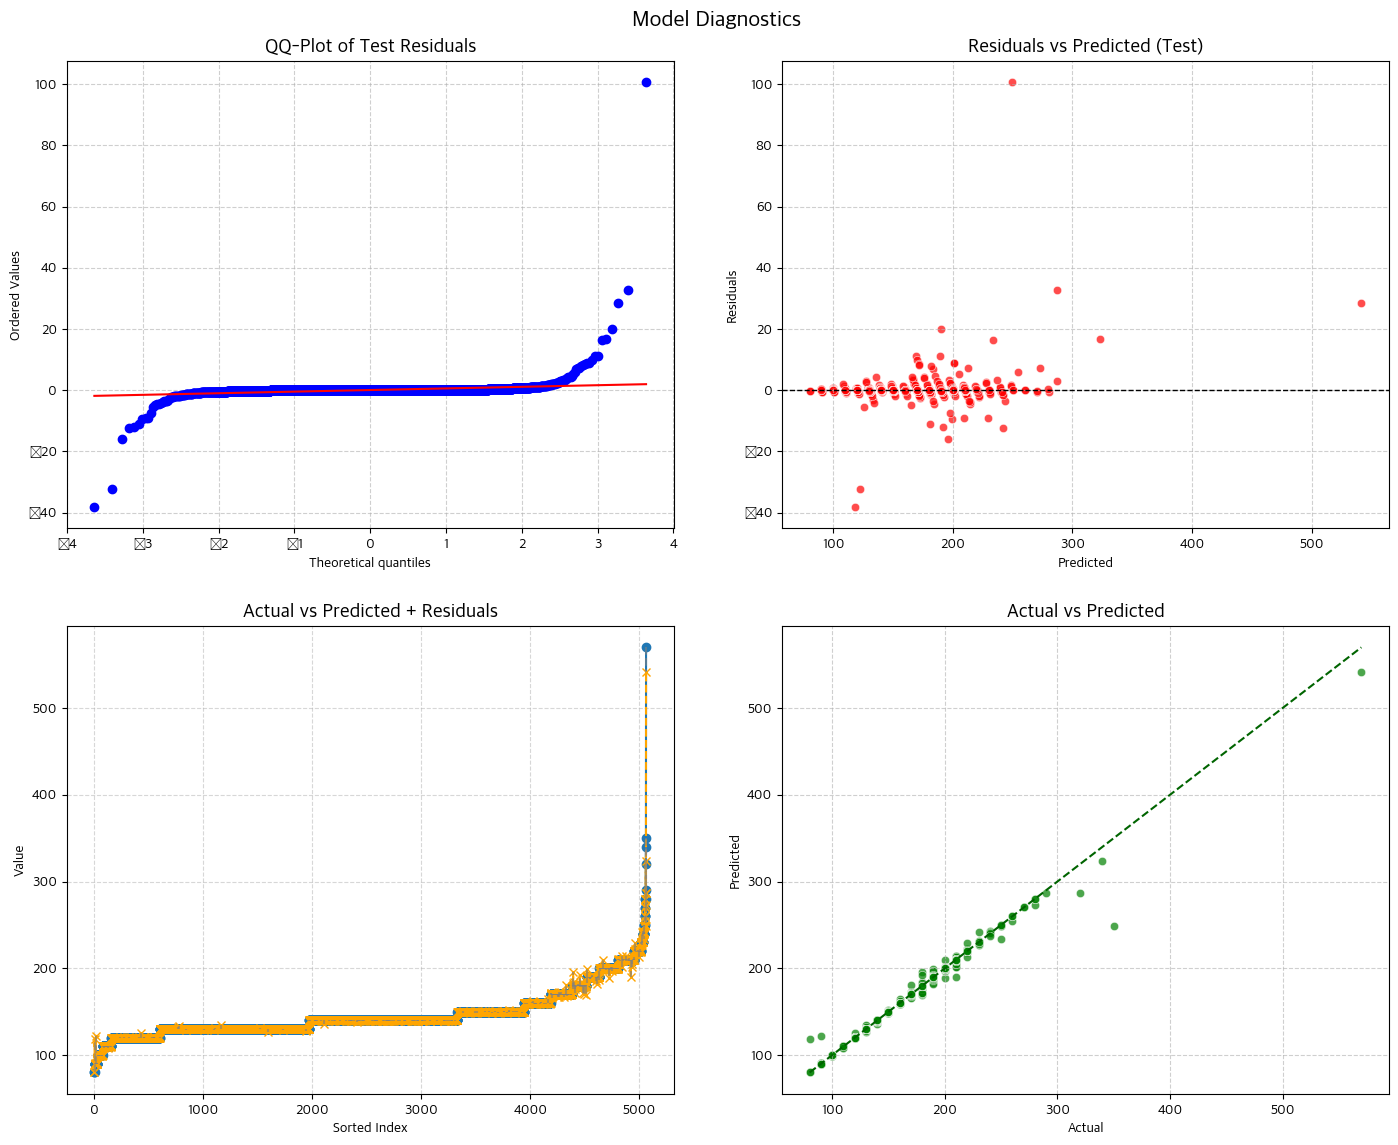

[I 2025-10-16 15:51:38,150] A new study created in memory with name: no-name-beff42d7-17cf-4bf5-adc9-818e8d594237


Train Accuracy
Train RMSE : 0.189
Train R2   : 1.000
Train SMAPE : 0.05
----------------------------------------------------------------------------------------------------
Test Accuracy
Test RMSE : 1.888
Test R2   : 0.995
Test SMAPE : 0.12
학습할 Tree Features: 16 | ['step1_Ram 압력', 'step2_Ram 압력', 'step3_Ram 압력', 'step1_Rotor speed', 'step2_Rotor speed', 'step3_Rotor speed', 'step1_mix온도', 'step2_mix온도', 'step3_mix온도', 'step1_time', 'step2_time', 'step3_time', '필팩터', 'TA_AVG', 'TA_MAX', 'TA_MIN']
학습 Tree 데이터 수: 13541


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-10-16 15:51:48,281] Trial 0 finished with value: 8.867623457822297 and parameters: {'n_estimators': 2564, 'max_depth': 6, 'learning_rate': 0.004452074319317331, 'subsample': 0.816503953859258, 'gamma': 0.14354729422211737, 'reg_lambda': 0.29944355241440185}. Best is trial 0 with value: 8.867623457822297.
[I 2025-10-16 15:51:57,026] Trial 1 finished with value: 8.530448759402075 and parameters: {'n_estimators': 2548, 'max_depth': 8, 'learning_rate': 0.0565576729352623, 'subsample': 0.7054379177604505, 'gamma': 0.48886380833621357, 'reg_lambda': 0.051050053973019704}. Best is trial 1 with value: 8.530448759402075.
[I 2025-10-16 15:52:00,851] Trial 2 finished with value: 8.40712545598856 and parameters: {'n_estimators': 529, 'max_depth': 9, 'learning_rate': 0.020146781834435374, 'subsample': 0.7979532244382408, 'gamma': 0.2385360379537962, 'reg_lambda': 0.018117204900306806}. Best is trial 2 with value: 8.40712545598856.
[I 2025-10-16 15:52:05,418] Trial 3 finished with value: 8.9

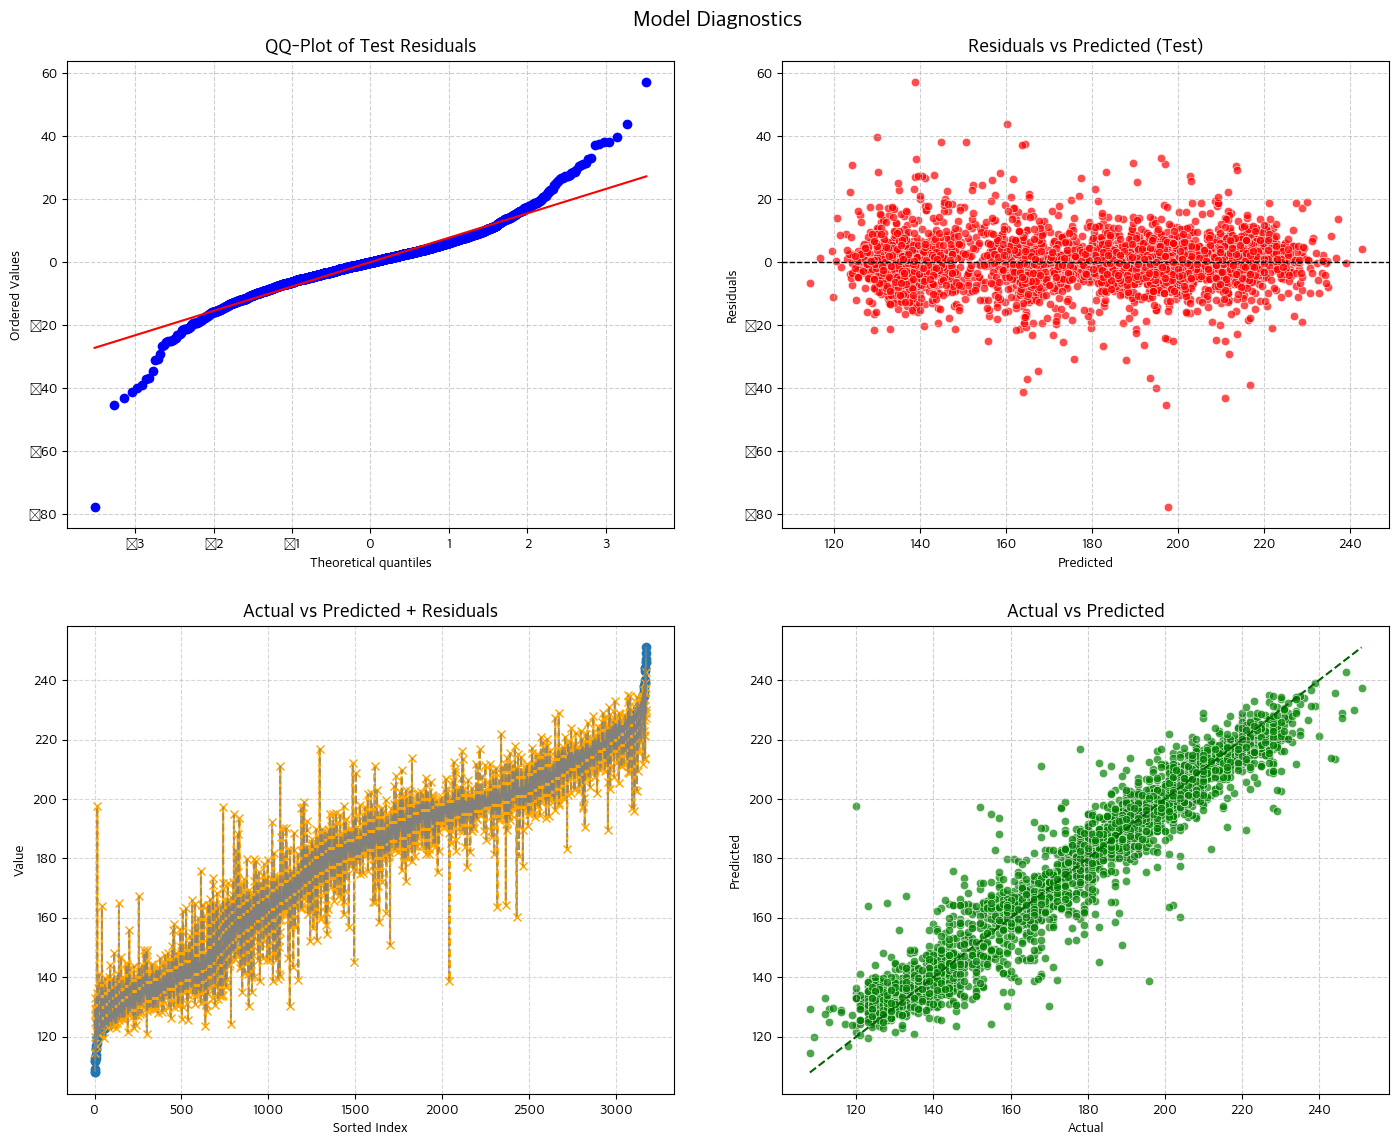

[I 2025-10-16 15:55:41,060] A new study created in memory with name: no-name-b3733249-b876-4781-8b38-bc728aa3c7f3


Train Accuracy
Train RMSE : 1.562
Train R2   : 0.997
Train SMAPE : 0.68
----------------------------------------------------------------------------------------------------
Test Accuracy
Test RMSE : 7.992
Test R2   : 0.929
Test SMAPE : 3.26
학습할 Tree Features: 16 | ['step1_Ram 압력', 'step2_Ram 압력', 'step3_Ram 압력', 'step1_Rotor speed', 'step2_Rotor speed', 'step3_Rotor speed', 'step1_mix온도', 'step2_mix온도', 'step3_mix온도', 'step1_time', 'step2_time', 'step3_time', '필팩터', 'TA_AVG', 'TA_MAX', 'TA_MIN']
학습 Tree 데이터 수: 9329


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-10-16 15:55:52,605] Trial 0 finished with value: 25.91383215441267 and parameters: {'n_estimators': 964, 'max_depth': 11, 'learning_rate': 0.0022621376342622994, 'subsample': 0.7766429723331819, 'gamma': 0.332851615950162, 'reg_lambda': 0.15271275950635257}. Best is trial 0 with value: 25.91383215441267.
[I 2025-10-16 15:56:08,536] Trial 1 finished with value: 24.429594911866502 and parameters: {'n_estimators': 1794, 'max_depth': 10, 'learning_rate': 0.009222960341257485, 'subsample': 0.9180465464899541, 'gamma': 0.40044778493792155, 'reg_lambda': 0.0011883558449963306}. Best is trial 1 with value: 24.429594911866502.
[I 2025-10-16 15:56:19,289] Trial 2 finished with value: 24.091271001254285 and parameters: {'n_estimators': 1914, 'max_depth': 8, 'learning_rate': 0.007767664302078605, 'subsample': 0.7368564354713112, 'gamma': 0.3181567244403869, 'reg_lambda': 0.050010047954553126}. Best is trial 2 with value: 24.091271001254285.
[I 2025-10-16 15:56:25,662] Trial 3 finished with

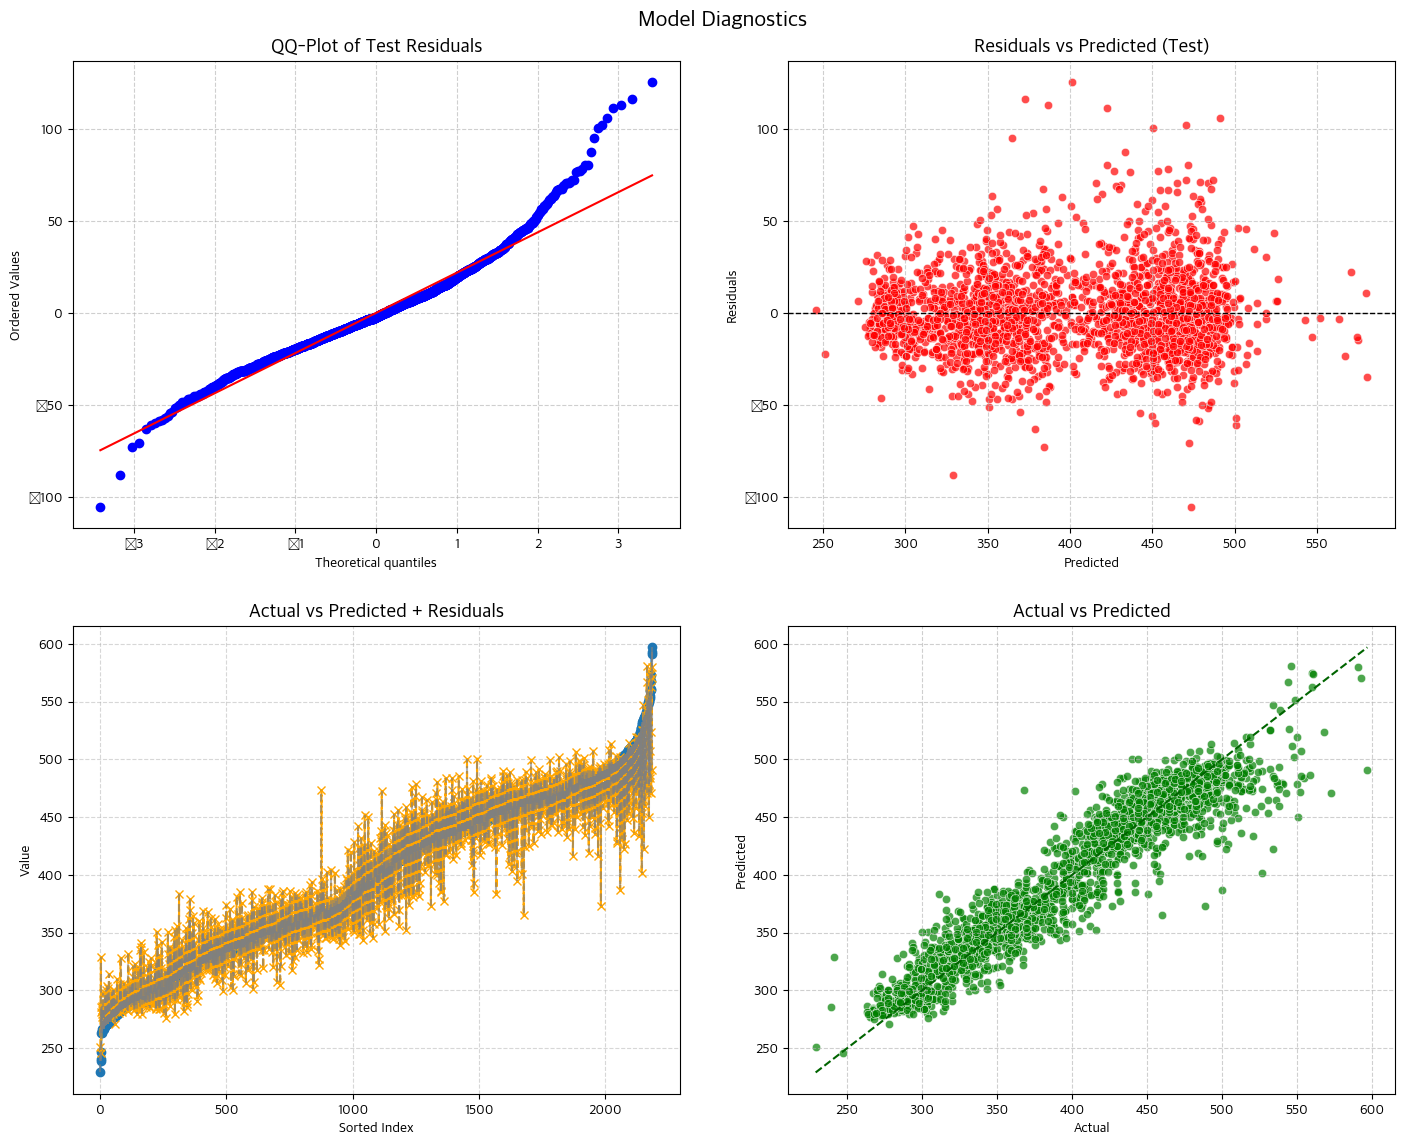

[I 2025-10-16 15:59:08,550] A new study created in memory with name: no-name-fd091bc9-dcd6-43c4-ac28-856286dc5018


Train Accuracy
Train RMSE : 9.854
Train R2   : 0.980
Train SMAPE : 1.90
----------------------------------------------------------------------------------------------------
Test Accuracy
Test RMSE : 22.276
Test R2   : 0.902
Test SMAPE : 4.17
학습할 Tree Features: 16 | ['step1_Ram 압력', 'step2_Ram 압력', 'step3_Ram 압력', 'step1_Rotor speed', 'step2_Rotor speed', 'step3_Rotor speed', 'step1_mix온도', 'step2_mix온도', 'step3_mix온도', 'step1_time', 'step2_time', 'step3_time', '필팩터', 'TA_AVG', 'TA_MAX', 'TA_MIN']
학습 Tree 데이터 수: 9329


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-10-16 15:59:12,215] Trial 0 finished with value: 1.7705708993439673 and parameters: {'n_estimators': 484, 'max_depth': 9, 'learning_rate': 0.0033145430187868324, 'subsample': 0.968868241608769, 'gamma': 0.2509564797629762, 'reg_lambda': 0.015613039451511275}. Best is trial 0 with value: 1.7705708993439673.
[I 2025-10-16 15:59:25,166] Trial 1 finished with value: 1.5925741119304835 and parameters: {'n_estimators': 1191, 'max_depth': 11, 'learning_rate': 0.0017889260965082271, 'subsample': 0.7005619509625034, 'gamma': 0.3595069751971553, 'reg_lambda': 0.02455594754064159}. Best is trial 1 with value: 1.5925741119304835.
[I 2025-10-16 15:59:40,876] Trial 2 finished with value: 1.4418987883478176 and parameters: {'n_estimators': 2584, 'max_depth': 10, 'learning_rate': 0.009957412269572198, 'subsample': 0.8279850056862108, 'gamma': 0.05439745066159024, 'reg_lambda': 1.19519266455246}. Best is trial 2 with value: 1.4418987883478176.
[I 2025-10-16 15:59:46,495] Trial 3 finished with v

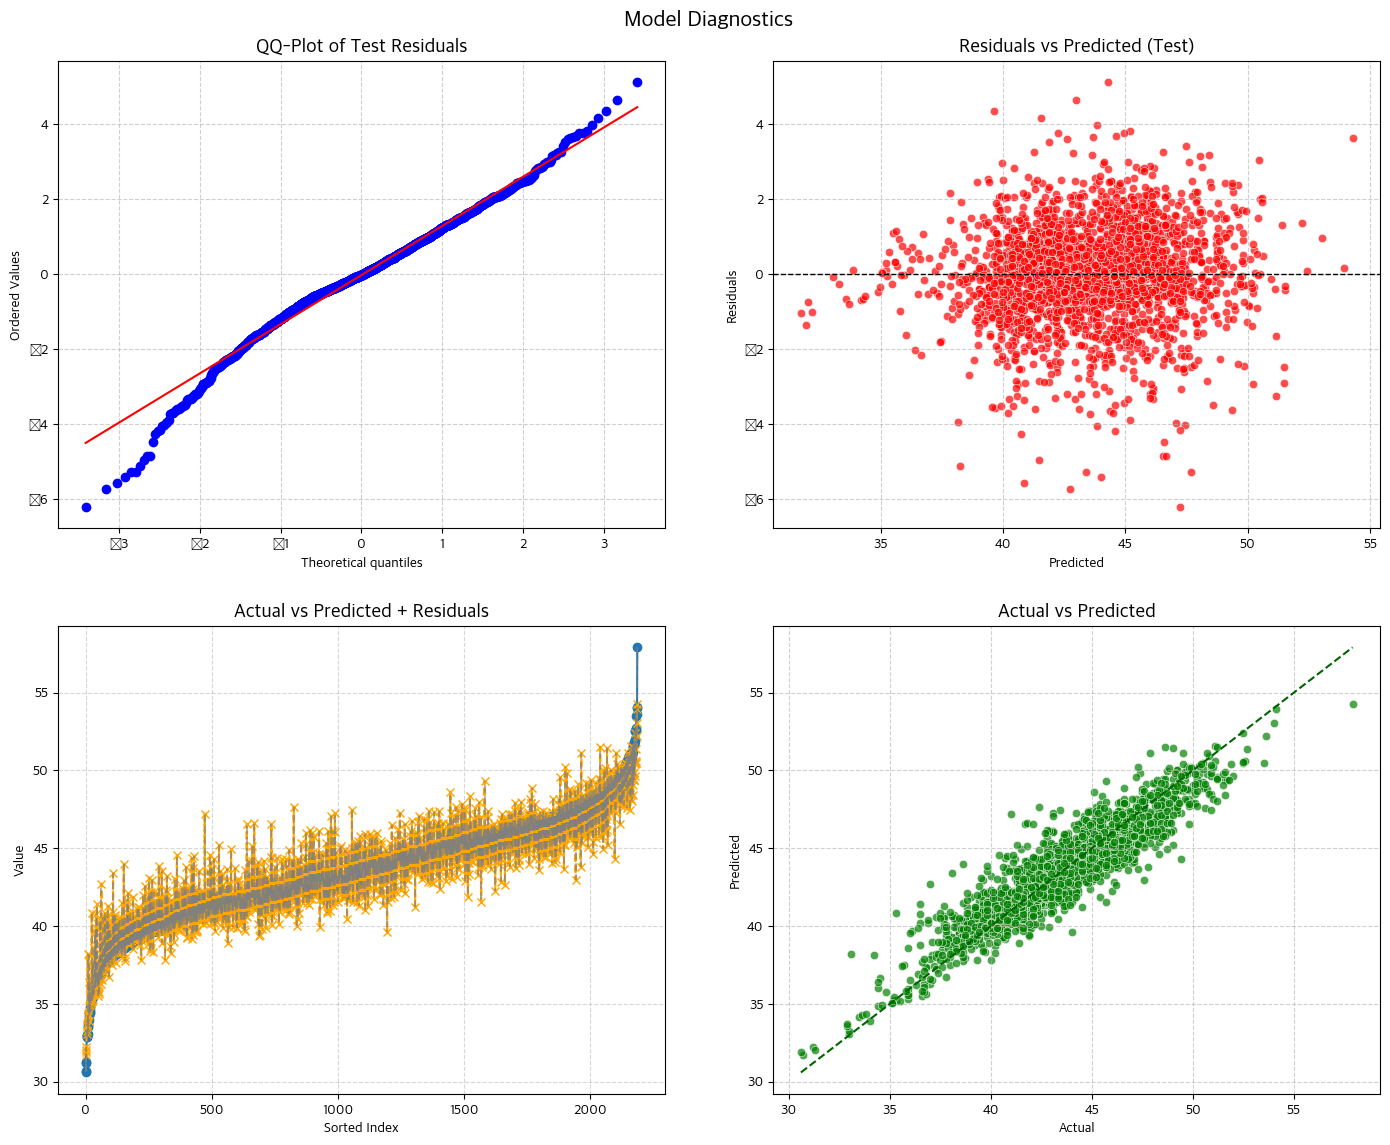

[I 2025-10-16 16:02:10,999] A new study created in memory with name: no-name-dc61e846-3544-435f-90b9-5d1eb0d375d8


Train Accuracy
Train RMSE : 0.312
Train R2   : 0.992
Train SMAPE : 0.53
----------------------------------------------------------------------------------------------------
Test Accuracy
Test RMSE : 1.319
Test R2   : 0.852
Test SMAPE : 2.28
학습할 Tree Features: 16 | ['step1_Ram 압력', 'step2_Ram 압력', 'step3_Ram 압력', 'step1_Rotor speed', 'step2_Rotor speed', 'step3_Rotor speed', 'step1_mix온도', 'step2_mix온도', 'step3_mix온도', 'step1_time', 'step2_time', 'step3_time', '필팩터', 'TA_AVG', 'TA_MAX', 'TA_MIN']
학습 Tree 데이터 수: 12888


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-10-16 16:02:16,671] Trial 0 finished with value: 1.086475158365421 and parameters: {'n_estimators': 1024, 'max_depth': 12, 'learning_rate': 0.027177568330466487, 'subsample': 0.7179290872788717, 'gamma': 0.16311448756103125, 'reg_lambda': 0.33074895324505565}. Best is trial 0 with value: 1.086475158365421.
[I 2025-10-16 16:02:19,949] Trial 1 finished with value: 1.081155426242838 and parameters: {'n_estimators': 710, 'max_depth': 7, 'learning_rate': 0.021416541874396247, 'subsample': 0.8056891681246946, 'gamma': 0.41588661575805397, 'reg_lambda': 0.0026891716784254453}. Best is trial 1 with value: 1.081155426242838.
[I 2025-10-16 16:02:28,323] Trial 2 finished with value: 1.0811970459931268 and parameters: {'n_estimators': 2991, 'max_depth': 9, 'learning_rate': 0.027832956611866, 'subsample': 0.7422921448118285, 'gamma': 0.19119942286113661, 'reg_lambda': 0.013454775320824054}. Best is trial 1 with value: 1.081155426242838.
[I 2025-10-16 16:02:36,814] Trial 3 finished with valu

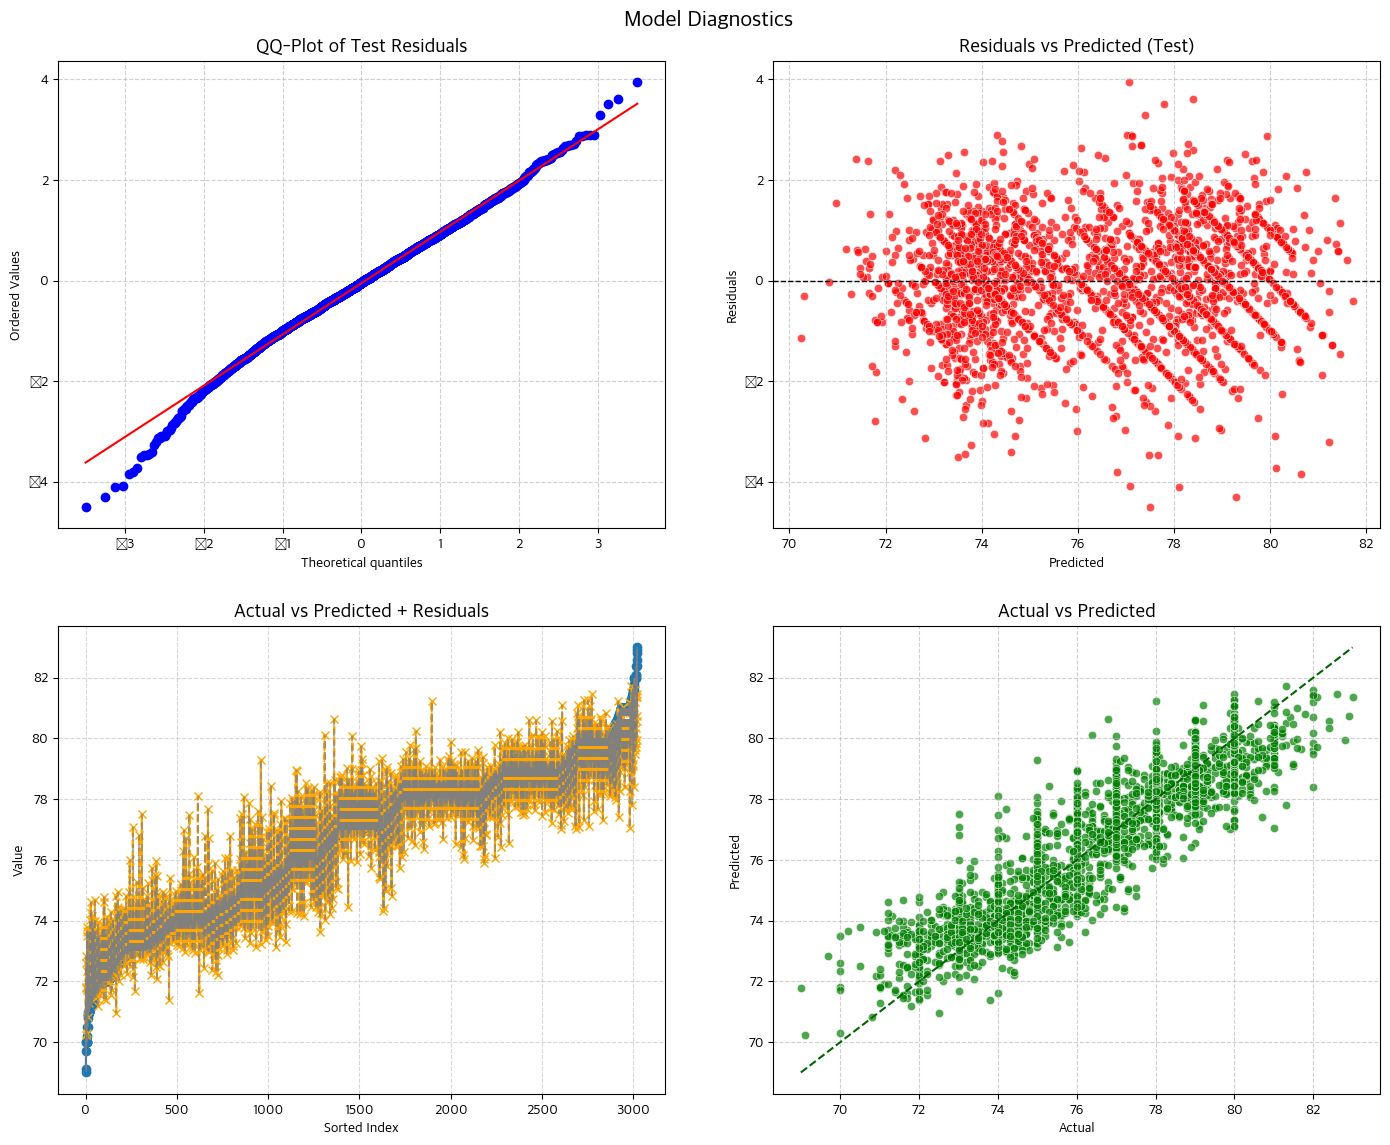

Train Accuracy
Train RMSE : 0.388
Train R2   : 0.977
Train SMAPE : 0.40
----------------------------------------------------------------------------------------------------
Test Accuracy
Test RMSE : 1.021
Test R2   : 0.838
Test SMAPE : 1.04


In [78]:
### Modelling 
# Cycle Time 
cycle_model, cycle_importance = train_tree(cycle_train_dataset, cycle_test_dataset, target_col='cycle time')

# CT90 
ct_model, ct_importance = train_tree(ct_train_dataset, ct_test_dataset, target_col='Ct 90_결과')

# Scorch 
sc_model, sc_importance = train_tree(sc_train_dataset, sc_test_dataset, target_col='Scorch (T5)_결과')

# Vm 
vm_model, vm_importance = train_tree(vm_train_dataset, vm_test_dataset, target_col='Vm (T5)_결과')

# Hard 
hard_model, hard_importance = train_tree(hard_train_dataset, hard_test_dataset, target_col='경도_결과')

In [84]:
### Feature Importance 
print('='*100)
print('Cycle Time')
print(cycle_importance)
print('-'*100)
print('CT90')
print(ct_importance)
print('-'*100)
print('Scorch')
print(sc_importance)
print('-'*100)
print('점도')
print(vm_importance)
print('-'*100)
print('경도')
print(hard_importance)
print('='*100)

Cycle Time
              Feature  Importance  rank
0         step3_mix온도    0.563981     1
1   step3_Rotor speed    0.149981     2
2         step2_mix온도    0.126364     3
3          step2_time    0.077120     4
4          step3_time    0.029740     5
5          step1_time    0.018763     6
6         step1_mix온도    0.010191     7
7                 필팩터    0.007306     8
8              TA_MIN    0.004568     9
9   step2_Rotor speed    0.003734    10
10  step1_Rotor speed    0.003576    11
11             TA_AVG    0.001870    12
12       step1_Ram 압력    0.001569    13
13       step2_Ram 압력    0.000642    14
14       step3_Ram 압력    0.000466    15
15             TA_MAX    0.000129    16
----------------------------------------------------------------------------------------------------
CT90
              Feature  Importance  rank
0          step1_time    0.429900     1
1   step2_Rotor speed    0.303151     2
2                 필팩터    0.115639     3
3   step1_Rotor speed    0.065791     4
4  

# 데이터 분할

In [61]:
# X 변수 리스트
features = [
    "step1_Rotor speed",
    "step2_Rotor speed",
    "step3_Rotor speed",
    "step1_mix온도",
    "step2_mix온도",
    "step3_mix온도",
    # "step1_mix온도Xtime",
    # "step2_mix온도Xtime",
    # "step3_mix온도Xtime",
    # "step1_time",
    # "step2_time",
    # "step3_time",
    "TA_AVG",
    "TA_MAX",
    "TA_MIN",
    "HM_AVG",
    "필팩터",
    "cluster"
]

# 점도, 경도, 사이클타임 모델을 위한 데이터셋 분리
df_viscosity = df3[features + [f"Vm ({cluster_dict[train_cluster]['var']})_결과"]].dropna()
df_hardness = df3[features + ["경도_결과"]].dropna()
df_ct90 = df3[features + ["Ct 90_결과"]].dropna()
df_st = df3[features + [f"Scorch ({cluster_dict[train_cluster]['var']})_결과"]].dropna()
df_cycletime = df3[features + ["cycle time"]].dropna()
df_s1 = df3[features + ["step1_time"]].dropna()
df_s2 = df3[features + ["step2_time"]].dropna()
df_s3 = df3[features + ["step3_time"]].dropna()

# 점도 모델 X, y 분리
X_v_train, X_v_test, y_v_train, y_v_test = train_test_split(
    df_viscosity[features], 
    df_viscosity[f"Vm ({cluster_dict[train_cluster]['var']})_결과"], 
    test_size=0.2, 
    random_state=random_seed
)

# 경도 모델 X, y 분리
X_h_train, X_h_test, y_h_train, y_h_test = train_test_split(
    df_hardness[features], 
    df_hardness["경도_결과"], 
    test_size=0.2, 
    random_state=random_seed
)

# Ct 90 모델 X, y 분리
X_ct_train, X_ct_test, y_ct_train, y_ct_test = train_test_split(
    df_ct90[features], 
    df_ct90["Ct 90_결과"], 
    test_size=0.2, 
    random_state=random_seed
)

# Scorch (T5) 모델 X, y 분리
X_st_train, X_st_test, y_st_train, y_st_test = train_test_split(
    df_st[features], 
    df_st[f"Scorch ({cluster_dict[train_cluster]['var']})_결과"], 
    test_size=0.2, 
    random_state=random_seed
)

# 사이클타임 모델 X, y 분리
X_c_train, X_c_test, y_c_train, y_c_test = train_test_split(
    df_cycletime[features], 
    df_cycletime["cycle time"], 
    test_size=0.2, 
    random_state=random_seed
)

# step1 시간 모델 X, y 분리
X_s1_train, X_s1_test, y_s1_train, y_s1_test = train_test_split(
    df_s1[["step1_Rotor speed", "step1_mix온도", "TA_AVG", "HM_AVG", "TA_MAX", "TA_MIN", "필팩터", "cluster"]], 
    df_s1["step1_time"], 
    test_size=0.2, 
    random_state=random_seed
)

# step2 시간 모델 X, y 분리
X_s2_train, X_s2_test, y_s2_train, y_s2_test = train_test_split(
    df_s2[["step2_Rotor speed", "step2_mix온도", "TA_AVG", "HM_AVG", "TA_MAX", "TA_MIN", "필팩터", "cluster"]], 
    df_s2["step2_time"], 
    test_size=0.2, 
    random_state=random_seed
)

# step3 시간 모델 X, y 분리
X_s3_train, X_s3_test, y_s3_train, y_s3_test = train_test_split(
    df_s3[["step3_Rotor speed", "step3_mix온도", "TA_AVG", "HM_AVG", "TA_MAX", "TA_MIN", "필팩터", "cluster"]], 
    df_s3["step3_time"], 
    test_size=0.2, 
    random_state=random_seed
)

# 모델링

In [ ]:
# XGBoost 하이퍼파라미터 탐색 공간 정의
space = [
    Real(0.01, 0.3, prior="log-uniform", name="learning_rate"),
    Integer(100, 1000, name="n_estimators"),
    Integer(3, 10, name="max_depth"),
    Real(0.6, 1.0, name="subsample"),
    Real(0.6, 1.0, name="colsample_bytree"),
    Real(0, 5, name="gamma"),
]

# 점도 모델 목적 함수 정의
# viscosity 모델
@use_named_args(space)
def objective_model_v(**params):
    model = xgb.XGBRegressor(
        objective="reg:squarederror", random_state=random_seed, n_jobs=-1, **params
    )
    score = cross_val_score(
        model, X_v_train, y_v_train, cv=3, scoring="r2", n_jobs=-1
    ).mean()
    return -score

# 경도 모델 목적 함수 정의
@use_named_args(space)
def objective_model_h(**params):
    model = xgb.XGBRegressor(
        objective="reg:squarederror", random_state=random_seed, n_jobs=-1, **params
    )
    score = cross_val_score(
        model, X_h_train, y_h_train, cv=3, scoring="r2", n_jobs=-1
    ).mean()
    return -score

# Ct 90 모델 목적 함수 정의
@use_named_args(space)
def objective_model_ct(**params):
    model = xgb.XGBRegressor(
        objective="reg:squarederror", random_state=random_seed, n_jobs=-1, **params
    )
    score = cross_val_score(
        model, X_ct_train, y_ct_train, cv=3, scoring="r2", n_jobs=-1
    ).mean()
    return -score

# Scorch 모델 목적 함수 정의
@use_named_args(space)
def objective_model_st(**params):
    model = xgb.XGBRegressor(
        objective="reg:squarederror", random_state=random_seed, n_jobs=-1, **params
    )
    score = cross_val_score(
        model, X_st_train, y_st_train, cv=3, scoring="r2", n_jobs=-1
    ).mean()
    return -score

# 사이클타임 모델 목적 함수 정의
@use_named_args(space)
def objective_model_c(**params):
    model = xgb.XGBRegressor(
        objective="reg:squarederror", random_state=random_seed, n_jobs=-1, **params
    )
    score = cross_val_score(
        model, X_c_train, y_c_train, cv=3, scoring="r2", n_jobs=-1
    ).mean()
    return -score

# step1_time 모델 목적 함수 정의
@use_named_args(space)
def objective_model_s1(**params):
    model = xgb.XGBRegressor(
        objective="reg:squarederror", random_state=random_seed, n_jobs=-1, **params
    )
    score = cross_val_score(
        model, X_s1_train, y_s1_train, cv=3, scoring="r2", n_jobs=-1
    ).mean()
    return -score

# step2_time 모델 목적 함수 정의
@use_named_args(space)
def objective_model_s2(**params):
    model = xgb.XGBRegressor(
        objective="reg:squarederror", random_state=random_seed, n_jobs=-1, **params
    )
    score = cross_val_score(
        model, X_s2_train, y_s2_train, cv=3, scoring="r2", n_jobs=-1
    ).mean()
    return -score

# step3_time 모델 목적 함수 정의
@use_named_args(space)
def objective_model_s3(**params):
    model = xgb.XGBRegressor(
        objective="reg:squarederror", random_state=random_seed, n_jobs=-1, **params
    )
    score = cross_val_score(
        model, X_s3_train, y_s3_train, cv=3, scoring="r2", n_jobs=-1
    ).mean()
    return -score

# 최적화 실행
# viscosity 모델 최적화
print("점도 모델 최적화 시작...")
result_gp_v = gp_minimize(
    objective_model_v, space, n_calls=40, random_state=random_seed, n_jobs=-1
)
best_params_v = {param.name: val for param, val in zip(space, result_gp_v.x)}
print("점도 모델 최적화 완료.")

# 경도 모델 최적화
print("경도 모델 최적화 시작...")
result_gp_h = gp_minimize(
    objective_model_h, space, n_calls=40, random_state=random_seed, n_jobs=-1
)
best_params_h = {param.name: val for param, val in zip(space, result_gp_h.x)}
print("경도 모델 최적화 완료.")

# Ct 90 모델 최적화
print("Ct 90 모델 최적화 시작...")
result_gp_ct = gp_minimize(
    objective_model_ct, space, n_calls=40, random_state=random_seed, n_jobs=-1
)
best_params_ct = {param.name: val for param, val in zip(space, result_gp_ct.x)}
print("Ct 90 모델 최적화 완료.")

# Scorch 모델 최적화
print("Scorch 모델 최적화 시작...")
result_gp_st = gp_minimize(
    objective_model_st, space, n_calls=40, random_state=random_seed, n_jobs=-1
)
best_params_st = {param.name: val for param, val in zip(space, result_gp_st.x)}
print("Scorch 모델 최적화 완료.")

# 사이클타임 모델 최적화
print("사이클타임 모델 최적화 시작...")
result_gp_c = gp_minimize(
    objective_model_c, space, n_calls=20, random_state=random_seed, n_jobs=-1
)
best_params_c = {param.name: val for param, val in zip(space, result_gp_c.x)}
print("사이클타임 모델 최적화 완료.")

# step1_time 모델 최적화
print("step1 시간 모델 최적화 시작...")
result_gp_s1 = gp_minimize(
    objective_model_s1, space, n_calls=20, random_state=random_seed, n_jobs=-1
)
best_params_s1 = {param.name: val for param, val in zip(space, result_gp_s1.x)}
print("step1 시간 모델 최적화 완료.")

# step2_time 모델 최적화
print("step2 시간 모델 최적화 시작...")
result_gp_s2 = gp_minimize(
    objective_model_s2, space, n_calls=20, random_state=random_seed, n_jobs=-1
)
best_params_s2 = {param.name: val for param, val in zip(space, result_gp_s2.x)}
print("step2 시간 모델 최적화 완료.")

# step3_time 모델 최적화
print("step3 시간 모델 최적화 시작...")
result_gp_s3 = gp_minimize(
    objective_model_s3, space, n_calls=20, random_state=random_seed, n_jobs=-1
)
best_params_s3 = {param.name: val for param, val in zip(space, result_gp_s3.x)}
print("step3 시간 모델 최적화 완료.")

# 최적 파라미터로 모델 학습 및 평가
# viscosity 모델
model_v_best = xgb.XGBRegressor(
    objective="reg:squarederror", random_state=random_seed, **best_params_v
)
# 경도 모델
model_h_best = xgb.XGBRegressor(
    objective="reg:squarederror", random_state=random_seed, **best_params_h
)
# Ct 90 모델
model_ct_best = xgb.XGBRegressor(
    objective="reg:squarederror", random_state=random_seed, **best_params_ct
)
# Scorch 모델
model_st_best = xgb.XGBRegressor(
    objective="reg:squarederror", random_state=random_seed, **best_params_st
)
# 사이클타임 모델
model_c_best = xgb.XGBRegressor(
    objective="reg:squarederror", random_state=random_seed, **best_params_c
)
# step1_time 모델
model_s1_best = xgb.XGBRegressor(
    objective="reg:squarederror", random_state=random_seed, **best_params_s1
)
# step2_time 모델
model_s2_best = xgb.XGBRegressor(
    objective="reg:squarederror", random_state=random_seed, **best_params_s2
)
# step3_time 모델
model_s3_best = xgb.XGBRegressor(
    objective="reg:squarederror", random_state=random_seed, **best_params_s3
)

# 모델 학습
# 점도 모델 학습
print("점도 모델 학습 시작...")
model_v_best.fit(X_v_train, y_v_train)
print("점도 모델 학습 완료.")
# 경도 모델 학습
print("경도 모델 학습 시작...")
model_h_best.fit(X_h_train, y_h_train)
print("경도 모델 학습 완료.")
# Ct 90 모델 학습
print("Ct 90 모델 학습 시작...")
model_ct_best.fit(X_ct_train, y_ct_train)
print("Ct 90 모델 학습 완료.")
# Scorch 모델 학습
print("Scorch 모델 학습 시작...")
model_st_best.fit(X_st_train, y_st_train)
print("Scorch 모델 학습 완료.")
# 사이클타임 모델 학습
print("사이클타임 모델 학습 시작...")
model_c_best.fit(X_c_train, y_c_train)
print("사이클타임 모델 학습 완료.")
# step1_time 모델 학습
print("step1 시간 모델 학습 시작...")
model_s1_best.fit(X_s1_train, y_s1_train)
print("step1 시간 모델 학습 완료.")
# step2_time 모델 학습
print("step2 시간 모델 학습 시작...")
model_s2_best.fit(X_s2_train, y_s2_train)
print("step2 시간 모델 학습 완료.")
# step3_time 모델 학습
print("step3 시간 모델 학습 시작...")
model_s3_best.fit(X_s3_train, y_s3_train)
print("step3 시간 모델 학습 완료.")

점도 모델 최적화 시작...
점도 모델 최적화 완료.
경도 모델 최적화 시작...
경도 모델 최적화 완료.
Ct 90 모델 최적화 시작...
Ct 90 모델 최적화 완료.
Scorch 모델 최적화 시작...
Scorch 모델 최적화 완료.
사이클타임 모델 최적화 시작...
사이클타임 모델 최적화 완료.
step1 시간 모델 최적화 시작...
step1 시간 모델 최적화 완료.
step2 시간 모델 최적화 시작...
step2 시간 모델 최적화 완료.
step3 시간 모델 최적화 시작...
step3 시간 모델 최적화 완료.
점도 모델 학습 시작...
점도 모델 학습 완료.
경도 모델 학습 시작...
경도 모델 학습 완료.
Ct 90 모델 학습 시작...
Ct 90 모델 학습 완료.
Scorch 모델 학습 시작...
Scorch 모델 학습 완료.
사이클타임 모델 학습 시작...
사이클타임 모델 학습 완료.
step1 시간 모델 학습 시작...
step1 시간 모델 학습 완료.
step2 시간 모델 학습 시작...
step2 시간 모델 학습 완료.
step3 시간 모델 학습 시작...
step3 시간 모델 학습 완료.


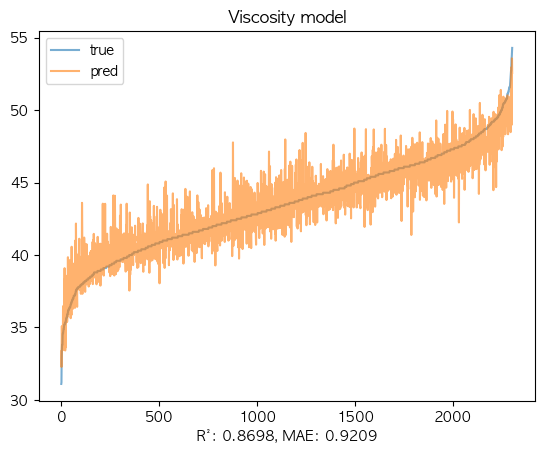

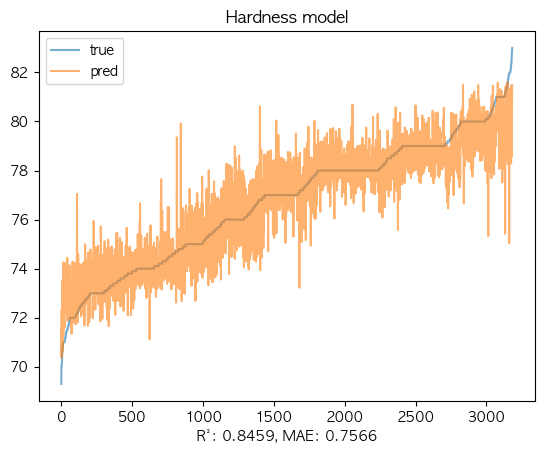

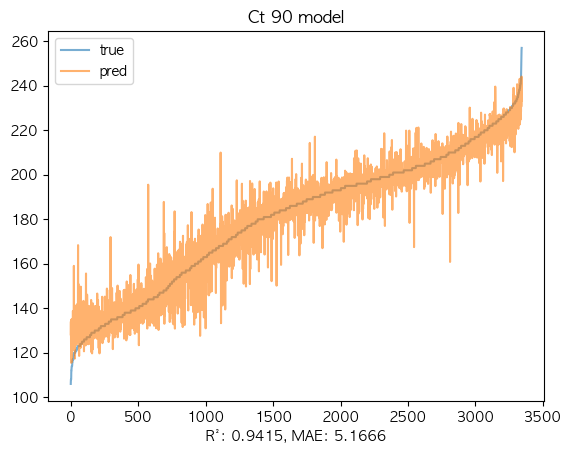

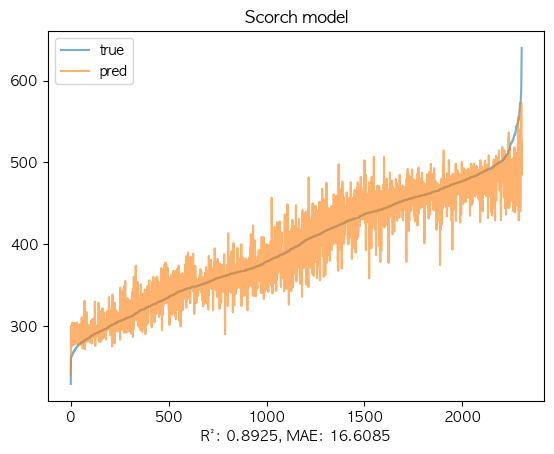

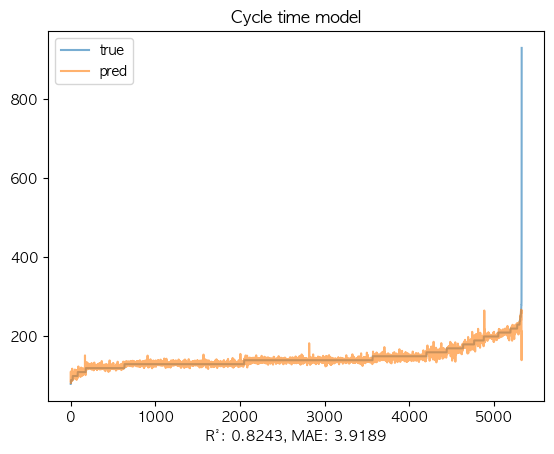

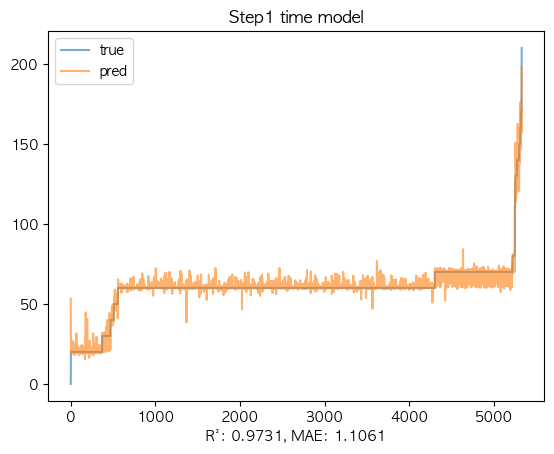

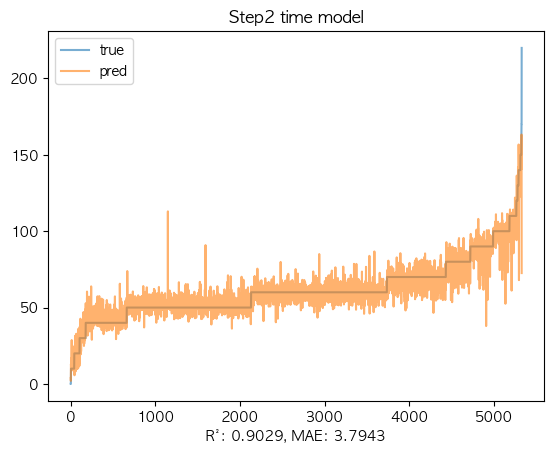

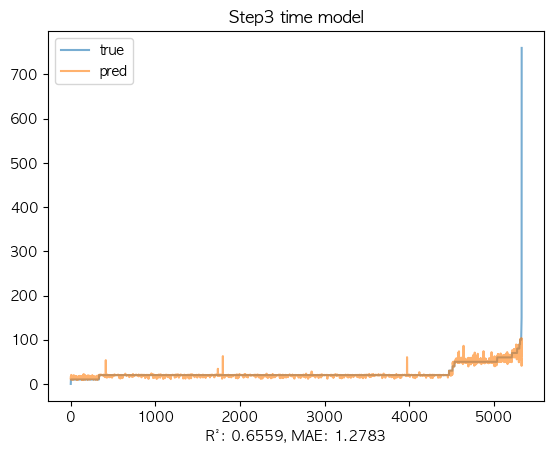

In [63]:
# 예측 및 평가
# 점도 모델 예측 및 평가
y_v_pred = model_v_best.predict(X_v_test)
r2_v = r2_score(y_v_test, y_v_pred)
mape_v = mean_absolute_percentage_error(y_v_test, y_v_pred)
mae_v = np.mean(np.abs(y_v_test - y_v_pred))
rmse_v = np.sqrt(np.mean((y_v_test - y_v_pred) ** 2))
# 점도 모델 시각화
plot_predictions(y_v_test, y_v_pred, "Viscosity model", subtitle="R²: {:.4f}, MAE: {:.4f}".format(r2_v, mae_v))

# 경도 모델 예측 및 평가
y_h_pred = model_h_best.predict(X_h_test)
r2_h = r2_score(y_h_test, y_h_pred)
mape_h = mean_absolute_percentage_error(y_h_test, y_h_pred)
mae_h = np.mean(np.abs(y_h_test - y_h_pred))
rmse_h = np.sqrt(np.mean((y_h_test - y_h_pred) ** 2))
# 경도 모델 시각화
plot_predictions(y_h_test, y_h_pred, "Hardness model", subtitle="R²: {:.4f}, MAE: {:.4f}".format(r2_h, mae_h))

# Ct 90 모델 예측 및 평가
y_ct_pred = model_ct_best.predict(X_ct_test)
r2_ct = r2_score(y_ct_test, y_ct_pred)
mape_ct = mean_absolute_percentage_error(y_ct_test, y_ct_pred)
mae_ct = np.mean(np.abs(y_ct_test - y_ct_pred))
rmse_ct = np.sqrt(np.mean((y_ct_test - y_ct_pred) ** 2))
# Ct 90 모델 시각화
plot_predictions(y_ct_test, y_ct_pred, "Ct 90 model", subtitle="R²: {:.4f}, MAE: {:.4f}".format(r2_ct, mae_ct))

# Scorch 모델 예측 및 평가
y_st_pred = model_st_best.predict(X_st_test)
r2_st = r2_score(y_st_test, y_st_pred)
mape_st = mean_absolute_percentage_error(y_st_test, y_st_pred)
mae_st = np.mean(np.abs(y_st_test - y_st_pred))
rmse_st = np.sqrt(np.mean((y_st_test - y_st_pred) ** 2))
# Scorch 모델 시각화
plot_predictions(y_st_test, y_st_pred, "Scorch model", subtitle="R²: {:.4f}, MAE: {:.4f}".format(r2_st, mae_st))

# 사이클타임 모델 예측 및 평가
y_c_pred = model_c_best.predict(X_c_test)
r2_c = r2_score(y_c_test, y_c_pred)
mape_c = mean_absolute_percentage_error(y_c_test, y_c_pred)
mae_c = np.mean(np.abs(y_c_test - y_c_pred))
rmse_c = np.sqrt(np.mean((y_c_test - y_c_pred) ** 2))
# 사이클타임 모델 시각화
plot_predictions(y_c_test, y_c_pred, "Cycle time model", subtitle="R²: {:.4f}, MAE: {:.4f}".format(r2_c, mae_c))

# step1_time 모델 예측 및 평가
y_s1_pred = model_s1_best.predict(X_s1_test)
r2_s1 = r2_score(y_s1_test, y_s1_pred)
mape_s1 = mean_absolute_percentage_error(y_s1_test, y_s1_pred)
mae_s1 = np.mean(np.abs(y_s1_test - y_s1_pred))
rmse_s1 = np.sqrt(np.mean((y_s1_test - y_s1_pred) ** 2))
# step1_time 모델 시각화
plot_predictions(y_s1_test, y_s1_pred, "Step1 time model", subtitle="R²: {:.4f}, MAE: {:.4f}".format(r2_s1, mae_s1))

# step2_time 모델 예측 및 평가
y_s2_pred = model_s2_best.predict(X_s2_test)
r2_s2 = r2_score(y_s2_test, y_s2_pred)
mape_s2 = mean_absolute_percentage_error(y_s2_test, y_s2_pred)
mae_s2 = np.mean(np.abs(y_s2_test - y_s2_pred))
rmse_s2 = np.sqrt(np.mean((y_s2_test - y_s2_pred) ** 2))
# step2_time 모델 시각화
plot_predictions(y_s2_test, y_s2_pred, "Step2 time model", subtitle="R²: {:.4f}, MAE: {:.4f}".format(r2_s2, mae_s2))

# step3_time 모델 예측 및 평가
y_s3_pred = model_s3_best.predict(X_s3_test)
r2_s3 = r2_score(y_s3_test, y_s3_pred)
mape_s3 = mean_absolute_percentage_error(y_s3_test, y_s3_pred)
mae_s3 = np.mean(np.abs(y_s3_test - y_s3_pred))
rmse_s3 = np.sqrt(np.mean((y_s3_test - y_s3_pred) ** 2))
# step3_time 모델 시각화
plot_predictions(y_s3_test, y_s3_pred, "Step3 time model", subtitle="R²: {:.4f}, MAE: {:.4f}".format(r2_s3, mae_s3))

In [64]:
# 저장해놓고 실행할 때 불러오기
print("학습 제품명: ", cluster_dict[train_cluster]['products'])

ct_trained_products = df3[["작업지시번호-배치", "Ct 90_결과"]].dropna().reset_index(drop=True)
print("제품명: ", set(cluster_dict[train_cluster]['products']) - set(ct_trained_products["작업지시번호-배치"].map(lambda x: x[6:16]).unique()), ", Ct 90 학습 불가")

st_trained_products = df3[["작업지시번호-배치", f"Scorch ({cluster_dict[train_cluster]['var']})_결과"]].dropna().reset_index(drop=True)
print("제품명: ", set(cluster_dict[train_cluster]['products']) - set(st_trained_products["작업지시번호-배치"].map(lambda x: x[6:16]).unique()), ", Scorch T5 학습 불가")

v_trained_products = df3[["작업지시번호-배치", f"Vm ({cluster_dict[train_cluster]['var']})_결과"]].dropna().reset_index(drop=True)
print("제품명: ", set(cluster_dict[train_cluster]['products']) - set(v_trained_products["작업지시번호-배치"].map(lambda x: x[6:16]).unique()), ", Viscosity 학습 불가")

h_trained_products = df3[["작업지시번호-배치", "경도_결과"]].dropna().reset_index(drop=True)
print("제품명: ", set(cluster_dict[train_cluster]['products']) - set(h_trained_products["작업지시번호-배치"].map(lambda x: x[6:16]).unique()), ", Hardness 학습 불가")

학습 제품명:  ['FFWED70284', 'FFWED70007', 'FFWED70267', 'FFWED70103', 'FFWED70199', 'FFSED70438', 'FFWED70033', 'FFWES60194', 'FFSED70498', 'FFSED70533', 'FFWED70321']
제품명:  set() , Ct 90 학습 불가
제품명:  set() , Scorch T5 학습 불가
제품명:  set() , Viscosity 학습 불가
제품명:  {'FFWES60194'} , Hardness 학습 불가


# 저장

In [65]:
model_ct_best.save_model(f"./{train_cluster}_model_ct90.json")
model_st_best.save_model(f"./{train_cluster}_model_st.json")
model_v_best.save_model(f"./{train_cluster}_model_v.json")
model_h_best.save_model(f"./{train_cluster}_model_h.json")
model_c_best.save_model(f"./{train_cluster}_model_c.json")
model_s1_best.save_model(f"./{train_cluster}_model_s1.json")
model_s2_best.save_model(f"./{train_cluster}_model_s2.json")
model_s3_best.save_model(f"./{train_cluster}_model_s3.json")

df3.to_parquet(f"./{train_cluster}_train_df.parquet", index=False)
recipe_df6.to_parquet(f"./{train_cluster}_recipe_df.parquet", index=False)

save_dict = {
    "cluster": train_cluster,
    "products": cluster_dict[train_cluster]['products'],
    "features": features,
    "train_df": {"path": f"./{train_cluster}_train_df.parquet", "shape": df3.shape},
    "recipe_df": {"path": f"./{train_cluster}_recipe_df.parquet", "shape": recipe_df6.shape},
    "ct_trained_products": list(ct_trained_products["작업지시번호-배치"].map(lambda x: x[6:16]).unique()),
    "st_trained_products": list(st_trained_products["작업지시번호-배치"].map(lambda x: x[6:16]).unique()),
    "v_trained_products": list(v_trained_products["작업지시번호-배치"].map(lambda x: x[6:16]).unique()),
    "h_trained_products": list(h_trained_products["작업지시번호-배치"].map(lambda x: x[6:16]).unique()),
    "ct_model": {"path": f"./{train_cluster}_model_ct90.json", "metrics": {"R2": r2_ct, "MAPE": mape_ct, "RMSE": rmse_ct, "MAE": mae_ct}},
    "st_model": {"path": f"./{train_cluster}_model_st.json", "metrics": {"R2": r2_st, "MAPE": mape_st, "RMSE": rmse_st, "MAE": mae_st}},
    "v_model": {"path": f"./{train_cluster}_model_v.json", "metrics": {"R2": r2_v, "MAPE": mape_v, "RMSE": rmse_v, "MAE": mae_v}},
    "h_model": {"path": f"./{train_cluster}_model_h.json", "metrics": {"R2": r2_h, "MAPE": mape_h, "RMSE": rmse_h, "MAE": mae_h}},
    "c_model": {"path": f"./{train_cluster}_model_c.json", "metrics": {"R2": r2_c, "MAPE": mape_c, "RMSE": rmse_c, "MAE": mae_c}},
    "s1_model": {"path": f"./{train_cluster}_model_s1.json", "metrics": {"R2": r2_s1, "MAPE": mape_s1, "RMSE": rmse_s1, "MAE": mae_s1}},
    "s2_model": {"path": f"./{train_cluster}_model_s2.json", "metrics": {"R2": r2_s2, "MAPE": mape_s2, "RMSE": rmse_s2, "MAE": mae_s2}},
    "s3_model": {"path": f"./{train_cluster}_model_s3.json", "metrics": {"R2": r2_s3, "MAPE": mape_s3, "RMSE": rmse_s3, "MAE": mae_s3}},
}

# save_dict 저장
import json
with open(f"./{train_cluster}_train_info.json", "w") as f:
    json.dump(save_dict, f, ensure_ascii=False, indent=4)

# 최적화

In [66]:
import pandas as pd
import json
import xgboost as xgb
from utils import *
from skopt import gp_minimize
from skopt.space import Integer, Real, Categorical
from skopt.utils import use_named_args
from skopt.plots import plot_convergence

user = "dogyeom"

In [67]:
# # import pandas as pd
# # import json
# # import xgboost as xgb

# # user = "dogyeom"

# cluster_dict = {
#     'cluster1': {'products': ["FFWED70284","FFWED70007","FFWED70267","FFWED70103","FFWED70199","FFSED70438","FFWED70033"],
#                  'var': 'T5'},
#     'cluster2': {'products': ["FFWES60194","FFSED70498","FFSED70533","FFWED70321"],
#                  'var': 'T5'},
#     'cluster3': {'products': ["FFWED70019","FFWED70102","FFWED70283","FFHED70076","FFWED70338"],
#                  'var': 'T3'},
#     'cluster4': {'products': ["FFHED70014","FFSED70032","FFHED70147"],
#                  'var': 'T3'},
#     'cluster5': {'products': ["FFHED60009","FFHED60006"], 
#                  'var': 'T3'}
#     }

In [96]:
path = "/Users/" + user + "/Library/CloudStorage/OneDrive-앰버로드/문서 - Solution/2502_화승/20.수행/22.분석과제/250408_분석_sm"

mix_df = pd.read_csv(f"{path}/mix_df.csv")
qa_df = pd.read_csv(f"{path}/qa_df.csv") # 목표값을 추출하기 위해 필요, UI에서 목표값을 받는다면 로딩하지 않아도 됨

In [141]:
run_cluster = "cluster1"
print(f"클러스터: {run_cluster}, 학습 제품명: {cluster_dict[run_cluster]['products']}")

with open(f"./{run_cluster}_train_info.json", "r") as f:
    load_dict = json.load(f)

train_df = pd.read_parquet(f"./{run_cluster}_train_df.parquet")
recipe_df = pd.read_parquet(f"./{run_cluster}_recipe_df.parquet")

# load model
model_ct_best = xgb.XGBRegressor()
model_ct_best.load_model(load_dict["ct_model"]["path"])

model_st_best = xgb.XGBRegressor()
model_st_best.load_model(load_dict["st_model"]["path"])

model_v_best = xgb.XGBRegressor()
model_v_best.load_model(load_dict["v_model"]["path"])

model_h_best = xgb.XGBRegressor()
model_h_best.load_model(load_dict["h_model"]["path"])

model_c_best = xgb.XGBRegressor()
model_c_best.load_model(load_dict["c_model"]["path"])

model_s1_best = xgb.XGBRegressor()
model_s1_best.load_model(load_dict["s1_model"]["path"])

model_s2_best = xgb.XGBRegressor()
model_s2_best.load_model(load_dict["s2_model"]["path"])

model_s3_best = xgb.XGBRegressor()
model_s3_best.load_model(load_dict["s3_model"]["path"])

클러스터: cluster1, 학습 제품명: ['FFWED70284', 'FFWED70007', 'FFWED70267', 'FFWED70103', 'FFWED70199', 'FFSED70438', 'FFWED70033', 'FFWES60194', 'FFSED70498', 'FFSED70533', 'FFWED70321']


In [72]:
user_product = 'FFWED70284'

if user_product not in load_dict["ct_trained_products"]:
    raise ValueError(f"{user_product}는 Ct 90 모델 학습에 포함되지 않은 제품입니다.")

if user_product not in load_dict["st_trained_products"]:
    raise ValueError(f"{user_product}는 Scorch 모델 학습에 포함되지 않은 제품입니다.")

if user_product not in load_dict["v_trained_products"]:
    raise ValueError(f"{user_product}는 Viscosity 모델 학습에 포함되지 않은 제품입니다.")

if user_product not in load_dict["h_trained_products"]:
    raise ValueError(f"{user_product}는 Hardness 모델 학습에 포함되지 않은 제품입니다.")

In [103]:
# 사용자에게 입력 받는 품질 지표 목표값
ct_target = int(qa_df[(qa_df["제품코드"] == user_product) & (qa_df["검사항목명"] == "Ct 90")]["기준"].value_counts().index[0].split("±")[0])
# ct_target = None
st_target = int(qa_df[(qa_df["제품코드"] == user_product) & (qa_df["검사항목명"] == f"Scorch ({cluster_dict[run_cluster]['var']})")]["기준"].value_counts().index[0].split("±")[0])
# st_target = None
v_target = int(qa_df[(qa_df["제품코드"] == user_product) & (qa_df["검사항목명"] == f"Vm ({cluster_dict[run_cluster]['var']})")]["기준"].value_counts().index[0].split("±")[0])
# v_target = None
h_target = int(qa_df[(qa_df["제품코드"] == user_product) & (qa_df["검사항목명"] == "경도")]["기준"].value_counts().index[0].split("±")[0])
# h_target = None
c_target = train_df[train_df["작업지시번호-배치"].map(lambda x:x[6:16]) == user_product]["cycle time"].quantile(0.25)
# c_target = None

# 사용자에게 입력 받는 날씨값
current_weather_conditions = {
    "TA_AVG": 29,
    "TA_MAX": 35.6,
    "TA_MIN": 23.9,
    "HM_AVG": 78.6,
}

print("목표 Ct 90: ", ct_target)
print("목표 Scorch (T5): ", st_target)
print("목표 Viscosity: ", v_target)
print("목표 Hardness: ", h_target)
print("목표 Cycle time: ", c_target)
print("현재 날씨 조건: ", current_weather_conditions)
print("제품:", user_product)

temp_key = mix_df[mix_df["아이템코드"] == user_product]["작업지시번호-배치"].iloc[-42]
ff = recipe_df[recipe_df["작업지시번호-배치"] == temp_key]["필팩터"].values[0]
print("필팩터:", ff)

목표 Ct 90:  200
목표 Scorch (T5):  450
목표 Viscosity:  47
목표 Hardness:  78
목표 Cycle time:  130.0
현재 날씨 조건:  {'TA_AVG': 29, 'TA_MAX': 35.6, 'TA_MIN': 23.9, 'HM_AVG': 78.6}
제품: FFWED70284
필팩터: 0.7783743872086526


In [130]:
range = "cluster"  # "product" or "cluster"
features = load_dict["features"]
n_opt_features = ["TA_AVG", "TA_MAX", "TA_MIN", "HM_AVG", "cluster", "필팩터"]
ref_features = ["step1_time", "step2_time", "step3_time"]
opt_features = [f for f in features if f not in n_opt_features]
opt_features = [f for f in opt_features if f not in ref_features]

fixed_df = pd.DataFrame([current_weather_conditions], columns=n_opt_features)
fixed_df["cluster"] = 6
fixed_df["필팩터"] = ff
full_df = pd.DataFrame(columns=features)
for col in features:
    if col in n_opt_features:
        full_df[col] = fixed_df[col]
    else:
        full_df[col] = 0
        
fixed_params = full_df[n_opt_features].iloc[0]

objective_function = create_objective_function(
    fixed_params=fixed_params, 
    all_features_list=features, 
    opt_features_list=opt_features,
    ct_target=ct_target,
    st_target=st_target,
    c_target=c_target,
    v_target=v_target, 
    h_target=h_target, 
    ct_model=model_ct_best,
    st_model=model_st_best,
    c_model=model_c_best,
    v_model=model_v_best,
    h_model=model_h_best,
    penalty_invalid=1e6,
    scales={"ct": load_dict["ct_model"]["metrics"]["RMSE"], 
            "st": load_dict["st_model"]["metrics"]["RMSE"],
            "c": load_dict["c_model"]["metrics"]["RMSE"],
            "v": load_dict["v_model"]["metrics"]["RMSE"],
            "h": load_dict["h_model"]["metrics"]["RMSE"]},
    weights={"ct": 2.0, "st": 3.0, "c": 1.0, "v": 2.0, "h": 2.0}
)

space = []
print("--- 최적화 탐색 범위 설정---")
temp_df = train_df[train_df["작업지시번호-배치"].map(lambda x: x[6:16]) == user_product]

for feature in opt_features:
    # 결측/빈 시리즈 대비
    if range == "product":
        s = temp_df[feature].dropna()
    elif range == "cluster":
        s = train_df[feature].dropna()
    if s.empty:
        # 전역 기본값이나 현재 full_df 값으로 대체 (필요에 맞게 조정)
        q05 = q95 = float(full_df.iloc[0].get(feature, 0.0))
    else:
        q05 = float(s.quantile(0.05))
        q95 = float(s.quantile(0.95))

    if not np.isfinite(q05) or not np.isfinite(q95) or q05 >= q95 or np.isclose(q05, q95):
        # ✅ 고정값은 Categorical 한 값으로
        dim = Categorical([q05], name=feature)
        print(f"feature '{feature}': 고정값 {q05:.2f} 으로 설정")
    else:
        # ✅ 범위 차원은 Real로 (이름 반드시 부여)
        dim = Real(q05, q95, name=feature)
        print(f"feature '{feature}': 범위 [{q05:.2f}, {q95:.2f}] 으로 설정")
    space.append(dim)
    
# 최적화 실행
print("최적화 시작...")
res = gp_minimize(
    objective_function, 
    space, 
    n_calls=300, 
    random_state=random_seed, 
    n_jobs=-1,
    n_initial_points=50,       
    acq_func="gp_hedge",             
    xi=0.05,                  
    noise="gaussian",        
    n_restarts_optimizer=10
)
print("최적화 완료.")

--- 최적화 탐색 범위 설정---
feature 'step1_Rotor speed': 범위 [31.00, 52.00] 으로 설정
feature 'step2_Rotor speed': 범위 [31.00, 51.88] 으로 설정
feature 'step3_Rotor speed': 범위 [25.67, 41.00] 으로 설정
feature 'step1_mix온도': 범위 [74.00, 105.00] 으로 설정
feature 'step2_mix온도': 범위 [106.00, 145.00] 으로 설정
feature 'step3_mix온도': 범위 [130.00, 148.00] 으로 설정
최적화 시작...
Ct 90: 210.8636 (target 200) | Scorch: 376.8841 (target 450) | Cycle Time: 164.7488 (target 130.0) | Viscosity: 44.3132 (target 47) | Hardness: 76.3291 (target 78)
Ct 90: 209.7992 (target 200) | Scorch: 334.3642 (target 450) | Cycle Time: 144.0723 (target 130.0) | Viscosity: 44.8778 (target 47) | Hardness: 76.0219 (target 78)
Ct 90: 214.5443 (target 200) | Scorch: 416.2463 (target 450) | Cycle Time: 155.8227 (target 130.0) | Viscosity: 43.4857 (target 47) | Hardness: 76.3813 (target 78)
Ct 90: 195.5631 (target 200) | Scorch: 345.2541 (target 450) | Cycle Time: 141.8662 (target 130.0) | Viscosity: 44.3803 (target 47) | Hardness: 76.1150 (target 78)
Ct 90: 21


              최적화 최종 결과
-> 최소 손실값(objective): 8.4407
   예측 Ct90: 194.2552
   예측 Scorch: 450.9578
   예측 Cycle Time: 131.7617
   예측 Viscosity: 45.6241
   예측 Hardness: 75.8598


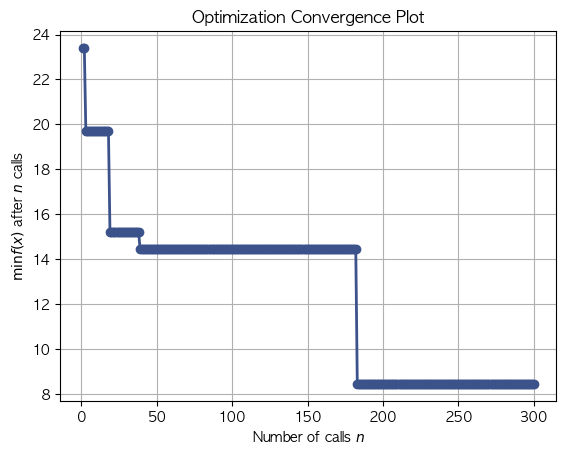

In [131]:
# 0) space에서 최적화 변수 이름을 확보 (가장 안전)
opt_names = [dim.name for dim in space]      # 예: ["step1_mix온도", "step1_mix온도Xtime", ...]
optimal_opt_params = res.x                   # skopt가 반환한 최적 해

# 1) 고정 + 최적화 파라미터 딕셔너리 결합
final_params_dict = dict(fixed_params)       # 고정 변수 투입
final_params_dict.update(dict(zip(opt_names, optimal_opt_params)))

# 2) 영향변수(ref_features) 계산 주입 (예: stepk_time = mix온도Xtime / mix온도)
final_params_dict = inject_ref_features(final_params_dict)   # 또는 _inject_product_features(...)

# 3) 모델 학습 시 사용한 피처 순서로 입력 벡터 구성
#    features == all_features_list (학습 시 사용한 순서와 동일해야 함)
final_params_vector = [final_params_dict.get(f, np.nan) for f in features]

# 4) 유효성 검사 (NaN/inf 방지)
arr = np.array(final_params_vector, dtype=float)
if not np.isfinite(arr).all():
    raise ValueError(f"최종 파라미터에 NaN/inf 존재: {[ (f, final_params_dict.get(f)) for f in features if not np.isfinite(final_params_dict.get(f, np.nan)) ]}")

# 5) 최종 입력 DF
optimal_df = pd.DataFrame([final_params_vector], columns=features)

# 6) 예측 및 결과 출력
pred_ct  = model_ct_best.predict(optimal_df)[0]
pred_st  = model_st_best.predict(optimal_df)[0]
pred_c   = model_c_best.predict(optimal_df)[0]
pred_v   = model_v_best.predict(optimal_df)[0]
pred_h   = model_h_best.predict(optimal_df)[0]

print("\n" + "=" * 50)
print("              최적화 최종 결과")
print("=" * 50)
print(f"-> 최소 손실값(objective): {res.fun:.4f}")  
print(f"   예측 Ct90: {pred_ct:.4f}")
print(f"   예측 Scorch: {pred_st:.4f}")
print(f"   예측 Cycle Time: {pred_c:.4f}")
print(f"   예측 Viscosity: {pred_v:.4f}")
print(f"   예측 Hardness: {pred_h:.4f}")

# 7) 수렴 플롯
plt.figure()
plot_convergence(res)
plt.title("Optimization Convergence Plot")
plt.show()

In [136]:
print("예상되는 Ct 90:", model_ct_best.predict(optimal_df)[0])
print("예상되는 Scorch:", model_st_best.predict(optimal_df)[0])
print("예상되는 Cycle Time:", model_c_best.predict(optimal_df)[0])
print("예상되는 Viscosity:", model_v_best.predict(optimal_df)[0])   
print("예상되는 Hardness:", model_h_best.predict(optimal_df)[0])

print("=" * 50)
print("              기존 데이터 통계")
print("=" * 50)
print("[Ct 90]")
print(f"min: {temp_df['Ct 90_결과'].min():.4f}")
print(f"25%: {temp_df['Ct 90_결과'].quantile(0.25):.4f}")
print(f"mean: {temp_df['Ct 90_결과'].mean():.4f}")
print(f"75%: {temp_df['Ct 90_결과'].quantile(0.75):.4f}")
print(f"max: {temp_df['Ct 90_결과'].max():.4f}")

print("\n[Scorch]")
print("min: {}".format(temp_df[f"Scorch ({cluster_dict[run_cluster]['var']})_결과"].min()))
print("25%: {}".format(temp_df[f"Scorch ({cluster_dict[run_cluster]['var']})_결과"].quantile(0.25)))
print("mean: {}".format(temp_df[f"Scorch ({cluster_dict[run_cluster]['var']})_결과"].mean()))
print("75%: {}".format(temp_df[f"Scorch ({cluster_dict[run_cluster]['var']})_결과"].quantile(0.75)))
print("max: {}".format(temp_df[f"Scorch ({cluster_dict[run_cluster]['var']})_결과"].max()))

print("\n[Viscosity]")
print("min: {}".format(temp_df[f"Vm ({cluster_dict[run_cluster]['var']})_결과"].min()))
print("25%: {}".format(temp_df[f"Vm ({cluster_dict[run_cluster]['var']})_결과"].quantile(0.25)))
print("mean: {}".format(temp_df[f"Vm ({cluster_dict[run_cluster]['var']})_결과"].mean()))
print("75%: {}".format(temp_df[f"Vm ({cluster_dict[run_cluster]['var']})_결과"].quantile(0.75)))
print("max: {}".format(temp_df[f"Vm ({cluster_dict[run_cluster]['var']})_결과"].max()))

print("\n[Hardness]")
print(f"min: {temp_df['경도_결과'].min():.4f}")
print(f"25%: {temp_df['경도_결과'].quantile(0.25):.4f}")
print(f"mean: {temp_df['경도_결과'].mean():.4f}")
print(f"75%: {temp_df['경도_결과'].quantile(0.75):.4f}")
print(f"max: {temp_df['경도_결과'].max():.4f}")

print("\n[Cycle Time]")
print(f"min: {temp_df['cycle time'].min():.4f}")
print(f"25%: {temp_df['cycle time'].quantile(0.25):.4f}")
print(f"mean: {temp_df['cycle time'].mean():.4f}")
print(f"75%: {temp_df['cycle time'].quantile(0.75):.4f}")
print(f"max: {temp_df['cycle time'].max():.4f}")

예상되는 Ct 90: 194.2552
예상되는 Scorch: 450.95776
예상되는 Cycle Time: 131.76172
예상되는 Viscosity: 45.624065
예상되는 Hardness: 75.859795
              기존 데이터 통계
[Ct 90]
min: 168.0000
25%: 207.0000
mean: 212.1769
75%: 217.0000
max: 237.0000

[Scorch]
min: 365.0
25%: 455.0
mean: 472.1556603773585
75%: 490.0
max: 617.0

[Viscosity]
min: 37.6
25%: 43.6
mean: 44.84983153638814
75%: 46.1
max: 53.3

[Hardness]
min: 74.0000
25%: 78.0000
mean: 78.5936
75%: 79.3000
max: 83.4000

[Cycle Time]
min: 110.0000
25%: 130.0000
mean: 141.3779
75%: 140.0000
max: 570.0000


## 제품코드 별 최적 배합표

In [138]:
final_params_dict["step1_time"] = model_s1_best.predict(pd.DataFrame([final_params_dict])[["step1_Rotor speed", "step1_mix온도", "TA_AVG", "HM_AVG", "TA_MAX", "TA_MIN", "필팩터", "cluster"]])[0]
final_params_dict["step2_time"] = model_s2_best.predict(pd.DataFrame([final_params_dict])[["step2_Rotor speed", "step2_mix온도", "TA_AVG", "HM_AVG", "TA_MAX", "TA_MIN", "필팩터", "cluster"]])[0]
final_params_dict["step3_time"] = model_s3_best.predict(pd.DataFrame([final_params_dict])[["step3_Rotor speed", "step3_mix온도", "TA_AVG", "HM_AVG", "TA_MAX", "TA_MIN", "필팩터", "cluster"]])[0]
final_params_dict

{'TA_AVG': 29.0,
 'TA_MAX': 35.6,
 'TA_MIN': 23.9,
 'HM_AVG': 78.6,
 'cluster': 6.0,
 '필팩터': 0.7783743872086526,
 'step1_Rotor speed': 51.67618099712476,
 'step2_Rotor speed': 45.0272839617234,
 'step3_Rotor speed': 37.833851246533754,
 'step1_mix온도': 99.39698308026607,
 'step2_mix온도': 130.29456139269263,
 'step3_mix온도': 135.44732408162673,
 'step1_time': 56.994553,
 'step2_time': 42.45715,
 'step3_time': 24.474817}

In [139]:
for k in [1,2,3]:
    t = final_params_dict.get(f"step{k}_time", None)
    m = final_params_dict.get(f"step{k}_mix온도", None)
    mt = final_params_dict.get(f"step{k}_mix온도Xtime", None)
    print(f"step{k}_time: {final_params_dict.get(f'step{k}_time', None)}")
    print(f"step{k}_mix온도: {final_params_dict.get(f'step{k}_mix온도', None)}")
    print(f"step{k}_Rotor speed: {final_params_dict.get(f'step{k}_Rotor speed', None)}")
    print()
    
print("필팩터:", final_params_dict.get("필팩터", None))

step1_time: 56.99455261230469
step1_mix온도: 99.39698308026607
step1_Rotor speed: 51.67618099712476

step2_time: 42.457149505615234
step2_mix온도: 130.29456139269263
step2_Rotor speed: 45.0272839617234

step3_time: 24.474817276000977
step3_mix온도: 135.44732408162673
step3_Rotor speed: 37.833851246533754

필팩터: 0.7783743872086526


In [142]:
# 기존 배합표
temp_key = mix_df[mix_df["아이템코드"] == user_product]["작업지시번호-배치"].iloc[-100]
org_mix_df = mix_df[mix_df["작업지시번호-배치"] == temp_key].reset_index(drop=True)[["STEP", "시간", "온도", "조건", "램압력", "로터속도"]]

org_mix_df["필팩터"] = None
org_mix_df.loc[0, "필팩터"] = recipe_df[recipe_df["작업지시번호-배치"] == temp_key]["필팩터"].values[0]

org_mix_df.to_csv(f"./{run_cluster}_{user_product}_org_mix_df.csv", index=False)
org_mix_df

,STEP,시간,온도,조건,램압력,로터속도,필팩터
0,1,NaN,NaN,NaN,5.0,50,0.778329
1,2,70.0,NaN,OR,5.0,50,None
2,3,NaN,NaN,NaN,5.0,40,None
3,4,NaN,135.0,OR,5.0,40,None
4,5,NaN,NaN,NaN,5.0,35,None
5,6,30.0,NaN,OR,5.0,35,None
6,7,NaN,NaN,NaN,5.0,30,None


In [143]:
# 최적 배합표
opt_mix_df = mix_df[mix_df["작업지시번호-배치"] == temp_key].reset_index(drop=True)[["STEP", "시간", "온도", "조건", "램압력", "로터속도"]].copy()
opt_mix_df.loc[1, "시간"]  = round(final_params_dict.get("step1_time", None), 2)
opt_mix_df.loc[1, "온도"]  = round(final_params_dict.get("step1_mix온도", None), 2)
opt_mix_df.loc[1, "로터속도"]  = round(final_params_dict.get("step1_Rotor speed", None), 2)
opt_mix_df.loc[1, "조건"] = "OR"

opt_mix_df.loc[3, "시간"]  = round(final_params_dict.get("step2_time", None), 2)
opt_mix_df.loc[3, "온도"]  = round(final_params_dict.get("step2_mix온도", None), 2)
opt_mix_df.loc[3, "로터속도"]  = round(final_params_dict.get("step2_Rotor speed", None), 2)
opt_mix_df.loc[3, "조건"] = "OR"

opt_mix_df.loc[5, "시간"]  = round(final_params_dict.get("step3_time", None), 2)
opt_mix_df.loc[5, "온도"]  = round(final_params_dict.get("step3_mix온도", None), 2)
opt_mix_df.loc[5, "로터속도"]  = round(final_params_dict.get("step3_Rotor speed", None), 2)
opt_mix_df.loc[5, "조건"] = "OR"

opt_mix_df["필팩터"] = None
opt_mix_df.loc[0, "필팩터"] = round(final_params_dict.get("필팩터", None), 4)

opt_mix_df.to_csv(f"./{run_cluster}_{user_product}_optimal_mix_df.csv", index=False)
opt_mix_df

/var/folders/rc/4ht3xz_x5kn029j7xhvrx9lw0000gn/T/ipykernel_95649/2457251943.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '51.68' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  opt_mix_df.loc[1, "로터속도"]  = round(final_params_dict.get("step1_Rotor speed", None), 2)


,STEP,시간,온도,조건,램압력,로터속도,필팩터
0,1,NaN,NaN,NaN,5.0,50.00,0.7784
1,2,56.990002,99.40,OR,5.0,51.68,None
2,3,NaN,NaN,NaN,5.0,40.00,None
3,4,42.459999,130.29,OR,5.0,45.03,None
4,5,NaN,NaN,NaN,5.0,35.00,None
5,6,24.469999,135.45,OR,5.0,37.83,None
6,7,NaN,NaN,NaN,5.0,30.00,None


In [144]:
# opt_mix_df의 "시간" 변수의 소수점 둘째 자리에서 반올림
opt_mix_df["시간"] = opt_mix_df["시간"].round(2)

In [145]:
opt_mix_df

,STEP,시간,온도,조건,램압력,로터속도,필팩터
0,1,NaN,NaN,NaN,5.0,50.00,0.7784
1,2,56.99,99.40,OR,5.0,51.68,None
2,3,NaN,NaN,NaN,5.0,40.00,None
3,4,42.46,130.29,OR,5.0,45.03,None
4,5,NaN,NaN,NaN,5.0,35.00,None
5,6,24.47,135.45,OR,5.0,37.83,None
6,7,NaN,NaN,NaN,5.0,30.00,None


In [125]:
recipe_df = pd.read_csv(f"{path}/recipe_df.csv")
temp_key = log_df[log_df["제품코드"] == user_product]["작업지시번호-배치"].unique()[-100]
recipe_df[recipe_df["작업지시번호-배치"] == temp_key][["자재코드", "소요량", "STEP", "낙차중량", "공급중량", "제로중량", "투입유형"]]


,자재코드,소요량,STEP,낙차중량,공급중량,제로중량,투입유형
1520044,R3931-0208,64.700,1.0,0.0,0.05,NaN,M
1520045,R3941-0024,42.300,1.0,NaN,NaN,NaN,M
1520046,R3962-0002,2.390,1.0,NaN,NaN,NaN,M
1520047,R3968-0002,1.000,1.0,NaN,NaN,NaN,M
1520048,R3968-0018,0.610,1.0,0.0,NaN,NaN,M
1520049,R3951-0010,38.300,1.0,0.5,3.00,0.2,M
1520050,R3911-0231,40.000,1.0,0.0,NaN,NaN,M
1520051,R3981-0002,0.800,1.0,0.0,NaN,0.2,M
1520052,R3964-0013,0.050,1.0,0.0,NaN,NaN,M
1520053,R3966-0008,4.000,1.0,0.0,NaN,NaN,M


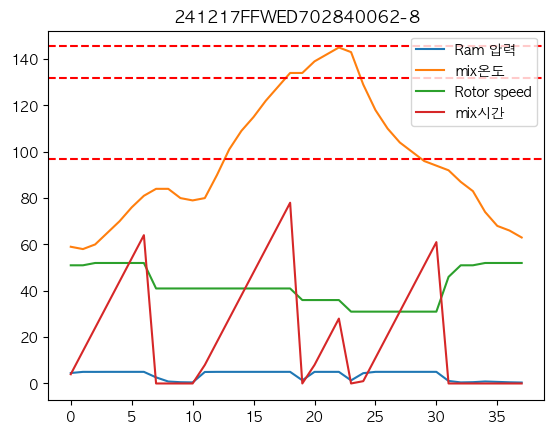

In [122]:
# log_df = pd.read_csv(f"{path}/log_df_10s.csv")

temp_key = log_df[log_df["제품코드"] == user_product]["작업지시번호-배치"].unique()[-100]
log_df[log_df["작업지시번호-배치"] == temp_key][["Ram 압력", "mix온도", "Rotor speed", "mix시간"]].reset_index(
    drop=True
).plot()
plt.title(temp_key)
plt.axhline(final_params_dict.get('step1_mix온도', None), color='r', linestyle='--')
plt.axhline(final_params_dict.get('step2_mix온도', None), color='r', linestyle='--')
plt.axhline(final_params_dict.get('step3_mix온도', None), color='r', linestyle='--')
plt.legend()
plt.show()